In [1]:
# импортируем необходимые библиотеки, классы и функции
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from sktime.datasets import load_airline
from sktime.forecasting.compose._reduce import _sliding_window_transform
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.base._fh import ForecastingHorizon
from sktime.forecasting.compose import (TransformedTargetForecaster,
                                        make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.performance_metrics.forecasting import (
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sktime.utils.plotting import plot_series

## 1. Временной ряд с трендом и мультипликативной сезонностью (набор данных Air Passengers)

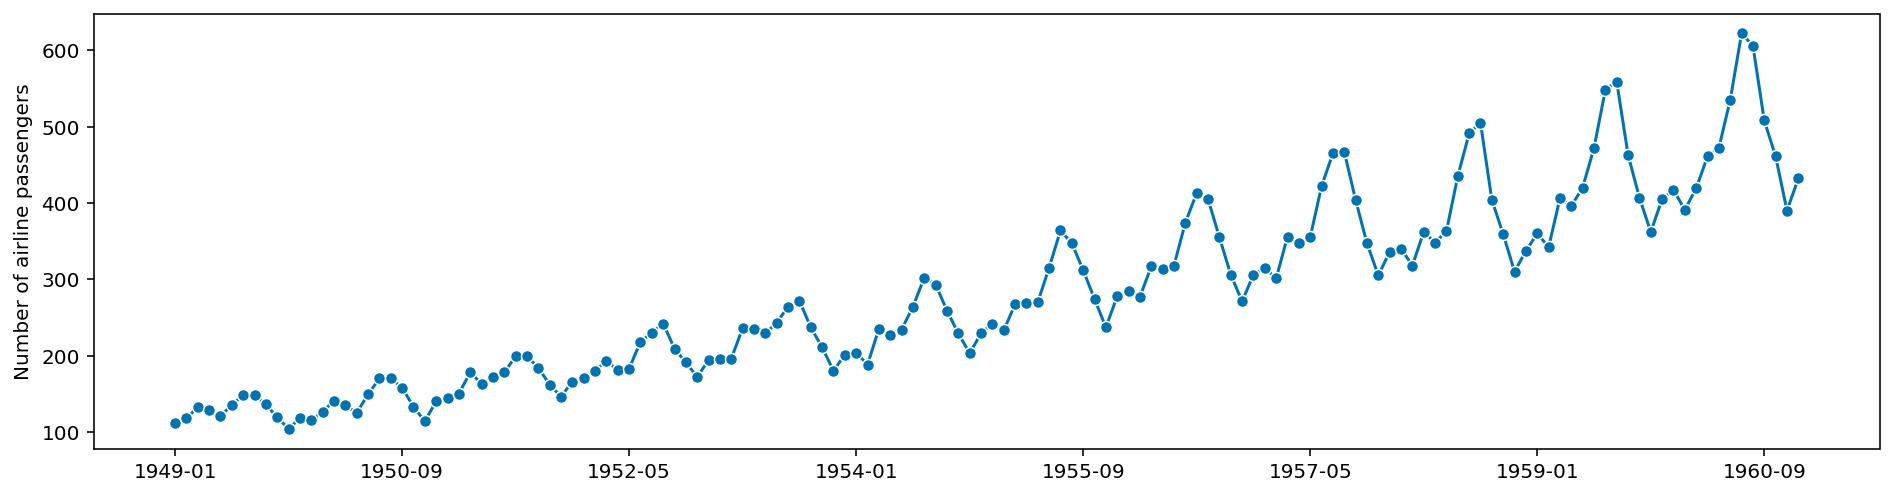

In [2]:
# загружаем данные
y = load_airline()

# визуализируем временной ряд
plot_series(y);

In [3]:
# разбиваем набор на обучающую и проверочную выборки
al_train, al_valid = y[0:len(y)-36], y[len(y)-36:]

In [4]:
# пишем функцию для сравнения фактических значений 
# и спрогнозированных значений на проверочной выборке,
# а также для вывода значений MAE и sMAPE по проверочной выборке
def plot_forecast(series_train, series_valid, forecast, forecast_int=None):
    mae = mean_absolute_error(series_valid, forecast)
    smape = mean_absolute_percentage_error(series_valid, forecast)
    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, sMAPE: {smape:.3f}", size=18)
    series_train.plot(label="train", color='b')
    series_valid.plot(label="valid", color='g')
    forecast.index = series_valid.index
    forecast.plot(label="forecast", color='r')
    if forecast_int is not None:
        plt.fill_between(
            series_valid.index,
            forecast_int['lower'],
            forecast_int['upper'],
            alpha=0.2,
            color='dimgray',
        )
    plt.legend(prop={'size': 16})
    plt.show()
    return mae, smape

In [5]:
# пишем функцию поиска оптимальной прогнозной модели
def grid_search_forecaster(train, valid, forecaster, param_grid):
    # задаем стратегию перекрестной проверки расширяющимся окном
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    # создаем экземпляр класса ForecastingGridSearchCV, выполняющего
    # поиск оптимальной прогнозной модели
    gscv = ForecastingGridSearchCV(
        forecaster, strategy='refit', cv=cv, param_grid=param_grid
    )
    # выполняем поиск
    gscv.fit(train)
    # печатаем наилучшие гиперпараметры
    print(f"best params: {gscv.best_params_}")
    # задаем относительный горизонт прогнозирования
    fh = np.arange(len(valid)) + 1
    # получаем прогнозы для нашего горизонта
    y_pred = gscv.predict(fh=fh)
    # визуализируем результаты
    mae, smape = plot_forecast(train, valid, y_pred)
    return mae, smape

best params: {'forecast__window_length': 36}


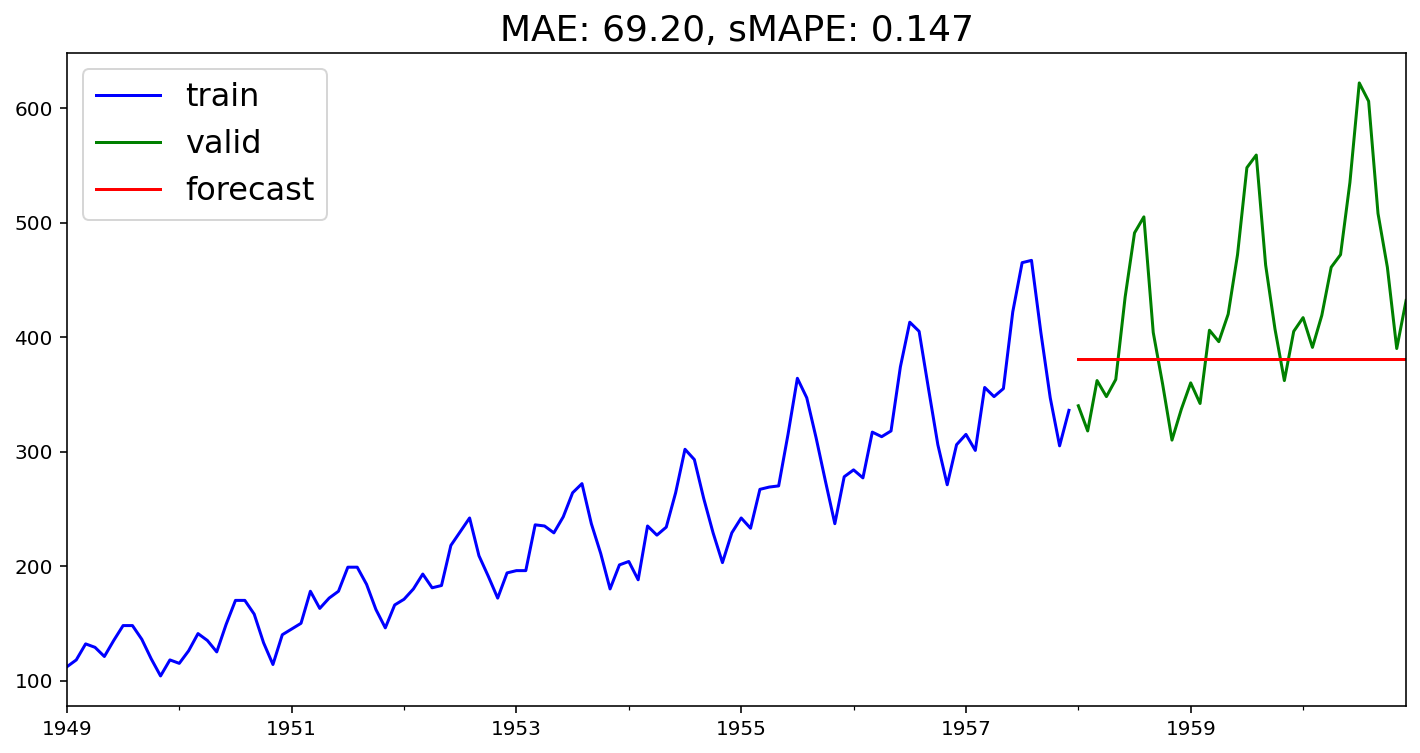

In [6]:
# создаем модель на основе класса LGBMRegressor
regressor = lgb.LGBMRegressor()

# создаем конвейер, состоящий из одной композитной модели (выполнение 
# редукции, т.е. превращение временного ряда в таблицы - массив 
# признаков и массив меток, и обучение модели LightGBM)
forecaster = TransformedTargetForecaster(
    [
        ('forecast', make_reduction(regressor, window_length=12, 
                                    strategy='recursive'))
    ]
)

# задаем сетку гиперпараметров
param_grid = {'forecast__window_length': [6, 12, 18, 24, 30, 36]}

# запускаем поиск и по результатам визуализируем прогнозы 
# с выводом метрик MAE и sMAPE
al_lgb_mae, al_lgb_mape = grid_search_forecaster(
    al_train, al_valid, forecaster, param_grid
)

best params: {'forecast__window_length': 30}


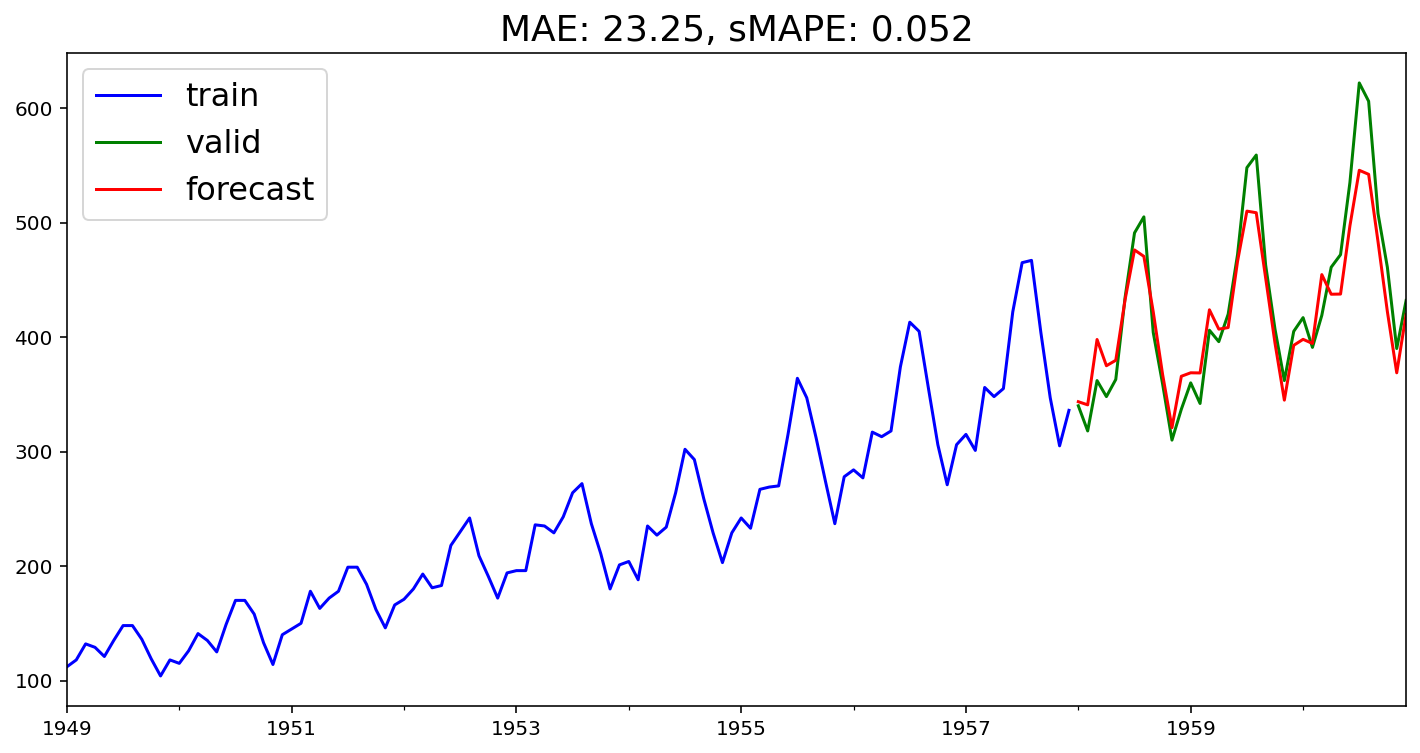

In [7]:
# создаем конвейер, состоящий из десезонализатора, 
# детрендера и композитной модели
forecaster = TransformedTargetForecaster(
    [
        ('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
        ('detrend', Detrender(forecaster=PolynomialTrendForecaster(
            degree=1))),
        ('forecast', make_reduction(
            regressor, window_length=12, strategy='recursive'))
    ]
)

# визуализируем прогнозы с выводом метрик MAE и sMAPE
al_lgb_mae, al_lgb_mape = grid_search_forecaster(
    al_train, al_valid, forecaster, param_grid
)

In [8]:
# вычислим коэффициенты сезонности

# задаем количество периодов
sp = 12

# для сезонной декомпозиции воспользуемся функцией seasonal_decompose()
# и возьмем первый коэффициент сезонности для каждого периодa
seasonal = seasonal_decompose(
    al_train, # временной ряд
    model='multiplicative', # тип сезонности
    period=sp, # периодичность (количество периодов)
).seasonal.iloc[:sp]
seasonal

1949-01    0.911904
1949-02    0.898524
1949-03    1.029701
1949-04    0.985319
1949-05    0.980130
1949-06    1.107406
1949-07    1.208846
1949-08    1.194426
1949-09    1.059141
1949-10    0.920206
1949-11    0.799321
1949-12    0.905076
Freq: M, Name: seasonal, dtype: float64

In [9]:
# пишем вспомогательную функцию seasonality_transform(),
# которая удаляет сезонность из временного ряда
def seasonality_transform(y, seasonal, model='additive'):
    """
    Выполняет удаление сезонности
    
    Параметры
    ----------
    y: временной ряд с сезонностью
    seasonal: массив коэффициентов сезонности
    model: тип сезонности (аддитивная или мультипликативная)
    
    Возвращает
    -------
    deseasonal_series: временной ряд с удаленной сезонностью
    """
    if model == 'additive':
        return y - seasonal
    else:
        return y / seasonal

In [10]:
# пишем вспомогательную функцию seasonality_inverse_transform(),
# которая восстанавливает сезонность временного ряда
def seasonality_inverse_transform(y, seasonal, model='additive'):
    """
    Выполняет восстановление сезонности
    
    Параметры
    ----------
    y: временной ряд с удаленной сезонностью
    seasonal: массив коэффициентов сезонности
    model: тип сезонности (аддитивная или мультипликативная)
    
    Возвращает
    -------
    seasonal_series: временной ряд с восстановленной сезонностью
    """
    if model == 'additive':
        return y + seasonal
    else:
        return y * seasonal

In [11]:
# сформируем массив с сезонными коэффициентами размером al_train,
# т.е. у каждого периода независимо от года будет один и тот же
# сезонный коэффициент, определенный выше
al_train_seasonal_coef = np.resize(np.roll(seasonal, shift=sp), 
                                   al_train.shape[0])
al_train_seasonal_coef

array([0.9119038 , 0.8985238 , 1.02970135, 0.98531875, 0.9801297 ,
       1.10740583, 1.20884594, 1.19442635, 1.05914132, 0.92020649,
       0.79932074, 0.90507594, 0.9119038 , 0.8985238 , 1.02970135,
       0.98531875, 0.9801297 , 1.10740583, 1.20884594, 1.19442635,
       1.05914132, 0.92020649, 0.79932074, 0.90507594, 0.9119038 ,
       0.8985238 , 1.02970135, 0.98531875, 0.9801297 , 1.10740583,
       1.20884594, 1.19442635, 1.05914132, 0.92020649, 0.79932074,
       0.90507594, 0.9119038 , 0.8985238 , 1.02970135, 0.98531875,
       0.9801297 , 1.10740583, 1.20884594, 1.19442635, 1.05914132,
       0.92020649, 0.79932074, 0.90507594, 0.9119038 , 0.8985238 ,
       1.02970135, 0.98531875, 0.9801297 , 1.10740583, 1.20884594,
       1.19442635, 1.05914132, 0.92020649, 0.79932074, 0.90507594,
       0.9119038 , 0.8985238 , 1.02970135, 0.98531875, 0.9801297 ,
       1.10740583, 1.20884594, 1.19442635, 1.05914132, 0.92020649,
       0.79932074, 0.90507594, 0.9119038 , 0.8985238 , 1.02970

In [12]:
# применим функцию seasonality_transform() к обучающему 
# временному ряду, чтобы убрать сезонность
al_train_deseasonal = seasonality_transform(
    al_train, al_train_seasonal_coef, 
    model='multiplicative')

# выведем первые 5 наблюдений обучающего 
# временного ряда с удаленной сезонностью
al_train_deseasonal.head()

1949-01    122.819973
1949-02    131.326516
1949-03    128.192509
1949-04    130.922100
1949-05    123.453049
Freq: M, Name: Number of airline passengers, dtype: float64

In [13]:
# мы просто разделили значения обучающего ряда 
# на соответствующие  сезонные коэффициенты
# выведем первые 5 наблюдений обучающего 
# временного ряда с удаленной сезонностью
(al_train / al_train_seasonal_coef).head()

1949-01    122.819973
1949-02    131.326516
1949-03    128.192509
1949-04    130.922100
1949-05    123.453049
Freq: M, Name: Number of airline passengers, dtype: float64

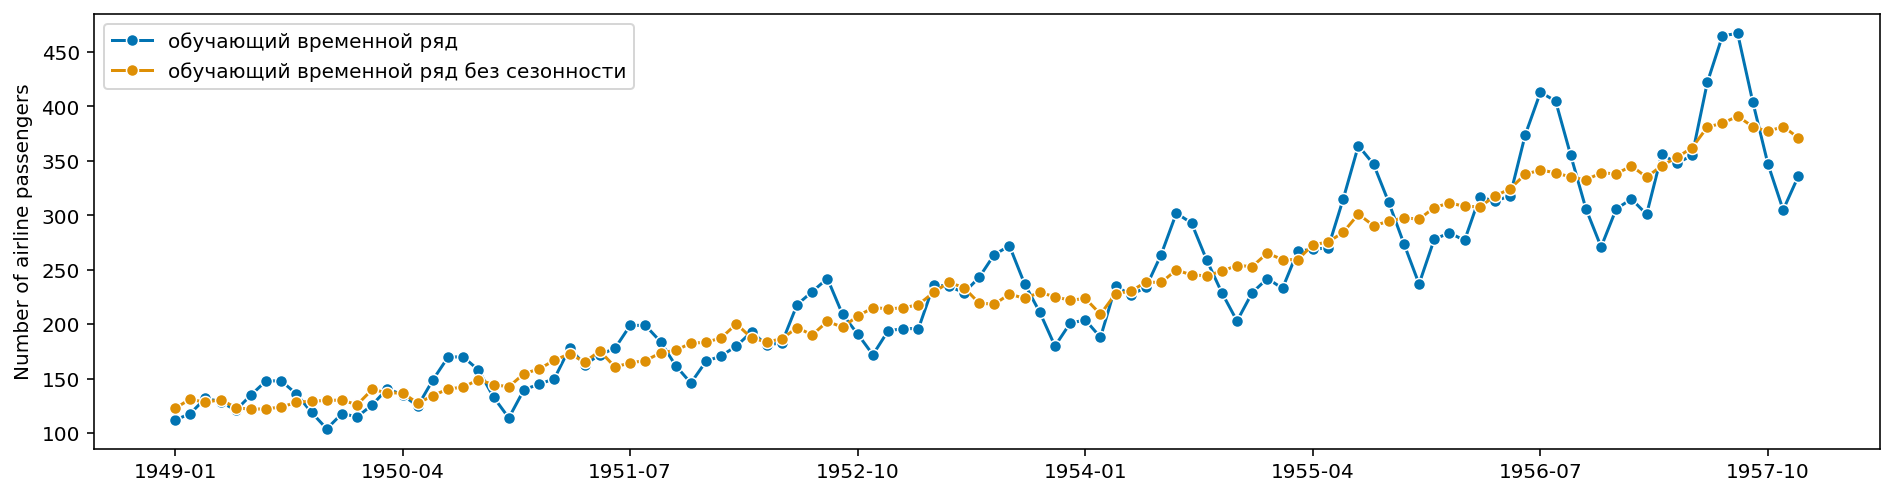

In [14]:
# визуализируем обучающий временной ряд 
# в исходном виде и после удаления сезонности
lst = ["обучающий временной ряд",
       "обучающий временной ряд без сезонности"]
plot_series(al_train, # исходный обучающий временной ряд
            al_train_deseasonal, # обучающий временной ряд без сезонности
            labels=lst);

In [15]:
# проверим, правильно ли мы удалили сезонность, сравним 
# наши результаты с результатами в sktime

# вычисляем коэффициенты сезонности и удаляем сезонность
# с помощью класса Deseasonalizer библиотеки sktime
season_transformer = Deseasonalizer(model='multiplicative', sp=sp)
al_train_deseasonal_sktime = season_transformer.fit_transform(al_train)

# проверим, получили ли мы одинаковые значения
(al_train_deseasonal == al_train_deseasonal_sktime).all()

True

In [16]:
# проверим, правильно ли мы восстановим сезонность, сравним 
# наши результаты с результатами в sktime

# применяем функцию seasonality_inverse_transform() к обучающему 
# временному ряду, чтобы восстановить сезонность
al_train_inv = seasonality_inverse_transform(al_train_deseasonal, 
                                             al_train_seasonal_coef, 
                                             model='multiplicative')

# восстанавливаем сезонность с помощью класса 
# Deseasonalizer библиотеки sktime
al_train_inv_sktime = season_transformer.inverse_transform(
    al_train_deseasonal_sktime)

# проверим, получили ли мы одинаковые значения
(al_train_inv == al_train_inv_sktime).all()

True

In [17]:
# пишем вспомогательную функцию trend_transform(), которая
# удаляет тренд из временного ряда
def trend_transform(y, trend, model='additive'):
    """
    Выполняет удаление тренда
    
    Параметры
    ----------
    y: временной ряд c трендом
    trend: предсказанный тренд
    model: тип тренда (аддитивный или мультипликативный)

    Возвращает
    -------
    detrended_series: временной ряд с удаленным трендом
    """
    if model == 'additive':
        return y - trend
    else:
        return y / trend

In [18]:
# пишем вспомогательную функцию trend_inverse_transform(), которая
# восстанавливает тренд для временного ряда
def trend_inverse_transform(y, trend, model='additive'):
    """
    Выполняет восстанавление тренда
    
    Параметры
    ----------
    y: временной ряд с удаленным трендом
    trend: предсказанный тренд
    model: тип тренда (аддитивный или мультипликативный)
    
    Возвращает
    -------
    trended_series: временной ряд с восстановленным трендом
    """
    if model == 'additive':
        return y + trend
    else:
        return y * trend

In [19]:
# теперь вручную вычисляем тренд для обучающего временного ряда
# с удаленной сезонностью

# создаем конвейер для прогнозирования тренда
regressor = make_pipeline(
    PolynomialFeatures(degree=1, include_bias=True),
    LinearRegression(fit_intercept=False))

# при прогнозировании тренда предиктором является номер периода,
# а зависимой переменной - значение временного ряда

# зададим длину обучающего временного ряда
n_timepoints = len(al_train)

# формируем массив признаков
X = np.arange(n_timepoints).reshape(-1, 1)

# обучаем конвейер
regressor.fit(X, al_train_deseasonal)

# получаем прогноз тренда c помощью нашего конвейера
al_train_trend_pred = regressor.predict(X)
al_train_trend_pred = pd.Series(al_train_trend_pred, 
                                index=al_train_deseasonal.index)

# выведем первые 5 предсказанных значений тренда для обучающего 
# временного ряда с удаленной сезонностью
al_train_trend_pred.head()

1949-01     97.648367
1949-02    100.137543
1949-03    102.626720
1949-04    105.115896
1949-05    107.605073
Freq: M, dtype: float64

In [20]:
# извлекаем коэффициенты линейной регрессии
linreg_coefs = regressor.named_steps['linearregression'].coef_
linreg_coefs

array([97.64836692,  2.48917642])

In [21]:
# теперь вычисляем тренд для обучающего временного ряда с удаленной сезонностью 
# с помощью класса PolynomialTrendForecaster библиотеки sktime

# зададим горизонт прогнозирования 
fh = ForecastingHorizon(al_train.index, is_relative=False)

# задаем модель для прогнозирования тренда 
regressor = PolynomialTrendForecaster(degree=1)

# обучаем модель на обучающем временном ряду без сезонности
regressor.fit(al_train_deseasonal)

# получаем прогноз тренда
al_train_trend_pred_sktime = regressor.predict(fh)

# выведем первые 5 предсказанных значений тренда для обучающего 
# временного ряда с удаленной сезонностью
al_train_trend_pred_sktime.head()

1949-01     97.648367
1949-02    100.137543
1949-03    102.626720
1949-04    105.115896
1949-05    107.605073
Freq: M, dtype: float64

In [22]:
# применяем функцию trend_transform() к обучающему временному 
# ряду без сезонности, чтобы убрать тренд вручную
al_train_detrend = trend_transform(al_train_deseasonal, 
                                   al_train_trend_pred)

# под капотом мы просто из значений обучающего ряда 
# без сезонности вычли значения тренда
# выведем первые 5 наблюдений обучающего временного ряда 
# с удаленной сезонностью и удаленным трендом
(al_train_deseasonal - al_train_trend_pred).head()

1949-01    25.171607
1949-02    31.188973
1949-03    25.565790
1949-04    25.806204
1949-05    15.847977
Freq: M, dtype: float64

In [23]:
# удаляем тренд из обучающего временного ряда без 
# сезонности с помощью класса Detrender
trend_transformer = Detrender(
    forecaster=PolynomialTrendForecaster(degree=1))
al_train_detrend_sktime = trend_transformer.fit_transform(
    al_train_deseasonal)

# выведем первые 5 наблюдений обучающего временного ряда 
# с удаленной сезонностью и удаленным трендом
al_train_detrend_sktime.head()

1949-01    25.171607
1949-02    31.188973
1949-03    25.565790
1949-04    25.806204
1949-05    15.847977
Freq: M, dtype: float64

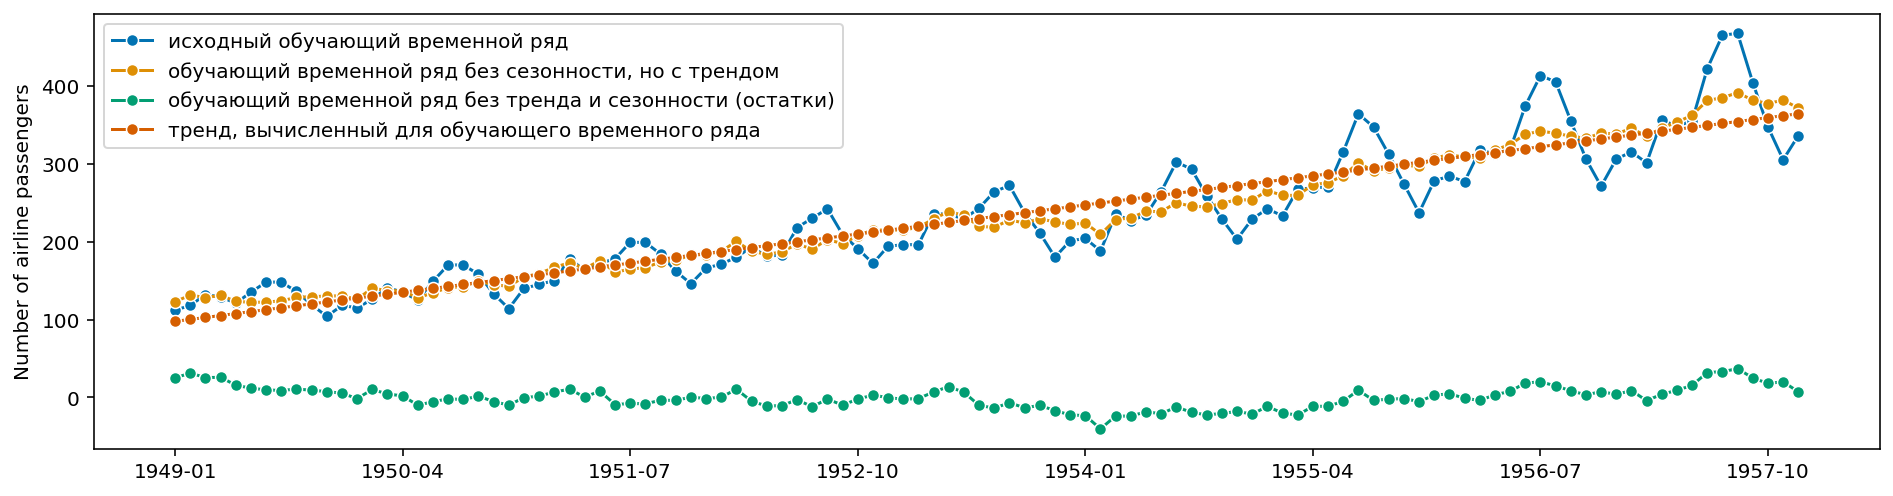

In [24]:
# визуализируем исходный временной ряд, временной ряд 
# без сезонности, но с трендом, временной ряд без 
# сезонности и тренда (остатки), а также сам тренд

# создаем список легенд
lst = ["исходный обучающий временной ряд", 
       "обучающий временной ряд без сезонности, но с трендом",
       "обучающий временной ряд без тренда и сезонности (остатки)",
       "тренд, вычисленный для обучающего временного ряда"]

plot_series(al_train, # исходный временной ряд
            al_train_deseasonal, # временной ряд без сезонности, но с трендом
            al_train_detrend, # временной ряд без сезонности и тренда
            al_train_trend_pred, # тренд
            labels=lst);

In [25]:
# проверим, правильно ли мы восстановим тренд, сравним 
# наши результаты с результатами в sktime

# восстанавливаем тренд для обучающего временного ряда без сезонности 
# вручную с помощью функции trend_inverse_transform()
al_train_inv = trend_inverse_transform(
    al_train_detrend, al_train_trend_pred)

# восстанавливаем тренд для обучающего временного ряда без сезонности
# с помощью класса Detrender библиотеки sktime
al_train_inv_sktime = trend_transformer.inverse_transform(
    al_train_detrend_sktime)

# проверим, получили ли мы одинаковые значения
(al_train_inv == al_train_inv_sktime).all()

True

In [26]:
# задаем модель LightGBM
regressor = lgb.LGBMRegressor()

# запишем шаги конвейера
steps = [
    ('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
    ('detrend', Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ('forecaster', make_reduction(
        regressor, window_length=12, strategy='recursive'))
        ]

# все шаги должны быть трансформерами, кроме последнего
transformers = steps[:-1]
# последний шаг должен быть прогнозной моделью
forecaster = steps[-1]

In [27]:
# cделаем копию обучающего набора, чтобы
# не изменять его в процессе транформации
al_train_trans = al_train.copy()

Выполняется 1-й шаг из 2 шагов трансформации deseasonalize
1949-01    122.819973
1949-02    131.326516
1949-03    128.192509
1949-04    130.922100
1949-05    123.453049
Freq: M, Name: Number of airline passengers, dtype: float64

Выполняется 2-й шаг из 2 шагов трансформации detrend
1949-01    25.171607
1949-02    31.188973
1949-03    25.565790
1949-04    25.806204
1949-05    15.847977
Freq: M, dtype: float64



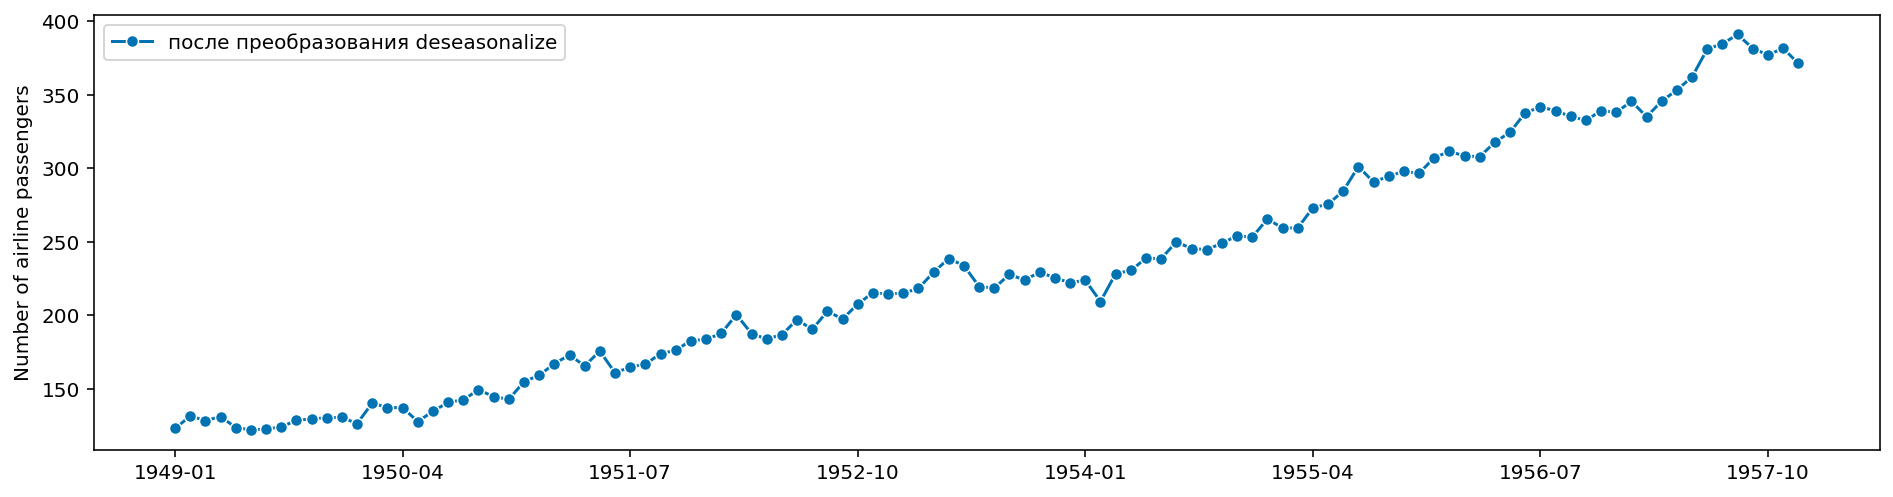

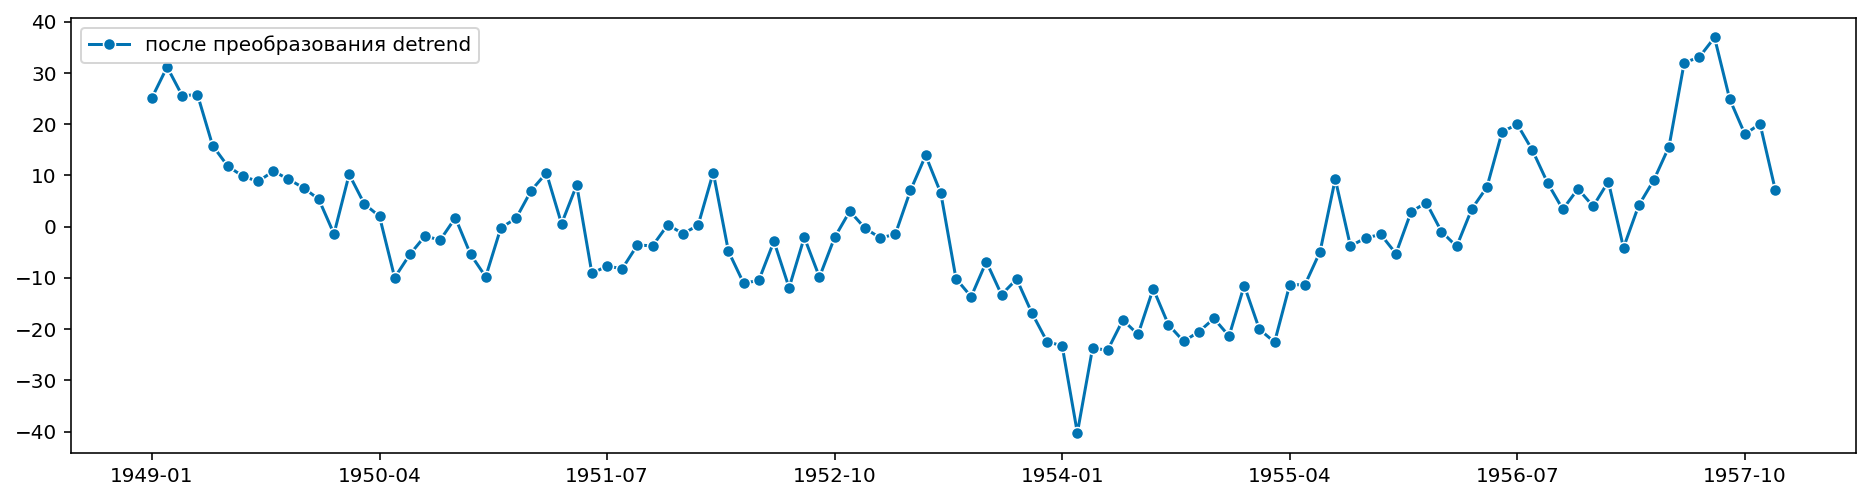

In [28]:
# выполняем транформацию обучающего временного ряда
# выполняем все преобразования в конвейере 
# (трансформеров может быть больше одного)
for idx, (name, transformer) in enumerate(transformers):
    print("Выполняется {}-й шаг из {} шагов трансформации {}".format(
        idx+1, len(transformers), name))
    # обучаем транформер и трансформируем обучающий временной ряд
    al_train_trans = transformer.fit_transform(al_train_trans)
    # печатаем первые 5 значений обучающего ряда
    print(al_train_trans.head())
    print("")
    # cмотрим на обучающий временной ряд
    plot_series(al_train_trans, labels=["после преобразования " + str(name)])
    # сохраняем обученный транформер для обратной 
    # трансформации временного ряда
    transformers[idx] = (name, transformer)

In [29]:
# выделяем модель
_, boost = forecaster
# обучаем модель
boost.fit(al_train_trans, X=None, fh=None);
# задаем относительный горизонт прогнозирования
fh = np.arange(len(al_valid)) + 1
# получаем прогнозы бустинга для проверочного временного ряда,
# видим, что прогнозы преимущественно являются константными
al_valid_trans_pred = boost.predict(fh=fh)
al_valid_trans_pred.head(15)

1958-01    12.438776
1958-02    12.576324
1958-03    15.936385
1958-04    17.764158
1958-05    17.764158
1958-06    17.764158
1958-07    17.764158
1958-08    17.764158
1958-09    17.764158
1958-10    17.764158
1958-11    17.764158
1958-12    17.764158
1959-01    17.764158
1959-02    17.764158
1959-03    17.764158
Freq: M, dtype: float64

In [30]:
# пишем функцию редукции
def transform(y, 
              window_length, 
              X=None):  
    """
    Функция превращает временной ряд в таблицу. Она разбивает 
    обучающий временной ряд на окна фиксированной длины 
    (длина определяется параметром window_length).
    Значения, попавшие в окно, будут предикторами, а следующее 
    значение будет значением зависимой переменной. 
    Мы решаем задачу регреcсии.
    """
    # для рекурсивной стратегии горизонт прогнозирования - это просто 
    # один шаг вперед, независимо от горизонта прогнозирования, 
    # который мы передаем модели  
    fh = ForecastingHorizon([1]) # всегда прогнозируем на 1 шаг вперед
    return _sliding_window_transform(
        y, window_length, fh, X)

In [31]:
# преобразовываем обучающий временной ряд без сезонности и тренда
# в таблицы, получаем массив меток и массив признаков
yt, Xt = transform(al_train_detrend,
                   window_length=12)

In [32]:
# сжимаем массив меток до одной оси 
yt = yt.ravel()

In [33]:
# создаем экземпляр класса LGBMRegressor
regressor = lgb.LGBMRegressor()
# обучаем модель
regressor.fit(Xt, yt);

In [34]:
# получим последнее окно (берем последние window_length наблюдений
# обучающего временного ряда без сезонности и тренда)
y_last = al_train_detrend.loc['1957-01':'1957-12'].to_numpy()
y_last

array([ 8.82187235, -4.10457004,  4.14365755,  9.10836851, 15.63095403,
       32.01559253, 33.12003937, 36.94912825, 24.9183556 , 18.07738763,
       20.07292009,  7.2493246 ])

In [35]:
# создаем массив из нулей, в который будем записывать прогнозы,
# равный горизонту прогнозирования
y_pred = np.zeros(len(fh))
print("Массив, куда будем сохранять прогнозы:\n\n%s" % y_pred)

Массив, куда будем сохранять прогнозы:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [36]:
# зададим количество столбцов
n_columns = 1

In [37]:
# зададим длину окна
window_length = 12

In [38]:
# cоздадим массив из нулей, количество элементов определяется
# длиной окна плюс длина горизонта прогнозирования
last = np.zeros((1, n_columns, window_length + len(fh)))
last

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [39]:
# запишем в этот массив значения из последнего окна
last[:, 0, :window_length] = y_last
last

array([[[ 8.82187235, -4.10457004,  4.14365755,  9.10836851,
         15.63095403, 32.01559253, 33.12003937, 36.94912825,
         24.9183556 , 18.07738763, 20.07292009,  7.2493246 ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ]]])

In [40]:
# рекурсивно создаем прогнозы для каждого шага
# горизонта прогнозирования
for i in range(0, len(fh)):
    
    # формируем скользящее окно, в которое отбираем значения, которые будут 
    # использоваться в качестве признаков для i-го наблюдения,
    # каждый раз окно сдвигается на один шаг вперед
    X = last[:, :, i:window_length + i]
    
    # получаем 2-мерный массив признаков
    X = X[0].reshape(1, -1)
    print("Массив признаков для прогнозирования {}-го наблюдения:".format(i))
    print(X)

    # получаем прогноз для i-го наблюдения
    y_pred[i] = regressor.predict(X)
    print("Прогноз {}-го наблюдения: ".format(i), y_pred[i])

    # добавим i-ый прогноз в массив last
    last[:, 0, window_length + i] = y_pred[i]
    print("----\n")

Массив признаков для прогнозирования 0-го наблюдения:
[[ 8.82187235 -4.10457004  4.14365755  9.10836851 15.63095403 32.01559253
  33.12003937 36.94912825 24.9183556  18.07738763 20.07292009  7.2493246 ]]
Прогноз 0-го наблюдения:  12.438775642237932
----

Массив признаков для прогнозирования 1-го наблюдения:
[[-4.10457004  4.14365755  9.10836851 15.63095403 32.01559253 33.12003937
  36.94912825 24.9183556  18.07738763 20.07292009  7.2493246  12.43877564]]
Прогноз 1-го наблюдения:  12.576323689649277
----

Массив признаков для прогнозирования 2-го наблюдения:
[[ 4.14365755  9.10836851 15.63095403 32.01559253 33.12003937 36.94912825
  24.9183556  18.07738763 20.07292009  7.2493246  12.43877564 12.57632369]]
Прогноз 2-го наблюдения:  15.936384876799151
----

Массив признаков для прогнозирования 3-го наблюдения:
[[ 9.10836851 15.63095403 32.01559253 33.12003937 36.94912825 24.9183556
  18.07738763 20.07292009  7.2493246  12.43877564 12.57632369 15.93638488]]
Прогноз 3-го наблюдения:  17.764

In [41]:
# напечатаем прогнозы
print(y_pred)

[12.43877564 12.57632369 15.93638488 17.76415787 17.76415787 17.76415787
 17.76415787 17.76415787 17.76415787 17.76415787 17.76415787 17.76415787
 17.76415787 17.76415787 17.76415787 17.76415787 17.76415787 17.76415787
 17.76415787 17.76415787 17.76415787 17.76415787 17.76415787 17.76415787
 17.76415787 17.76415787 17.76415787 17.76415787 17.76415787 17.76415787
 17.76415787 17.76415787 17.76415787 17.76415787 17.76415787 17.76415787]


In [42]:
# cравним прогнозы, вычисленные вручную и автоматически
(y_pred == al_valid_trans_pred).all()

True

Выполняется 1-й шаг из 2 шагов обратной трансформации detrend
1958-01    378.918196
1958-02    381.544920
1958-03    387.394158
1958-04    391.711107
1958-05    394.200283
Freq: M, dtype: float64

Выполняется 2-й шаг из 2 шагов обратной трансформации deseasonalize
1958-01    345.536941
1958-02    342.827191
1958-03    398.900287
1958-04    385.960298
1958-05    386.367405
Freq: M, dtype: float64



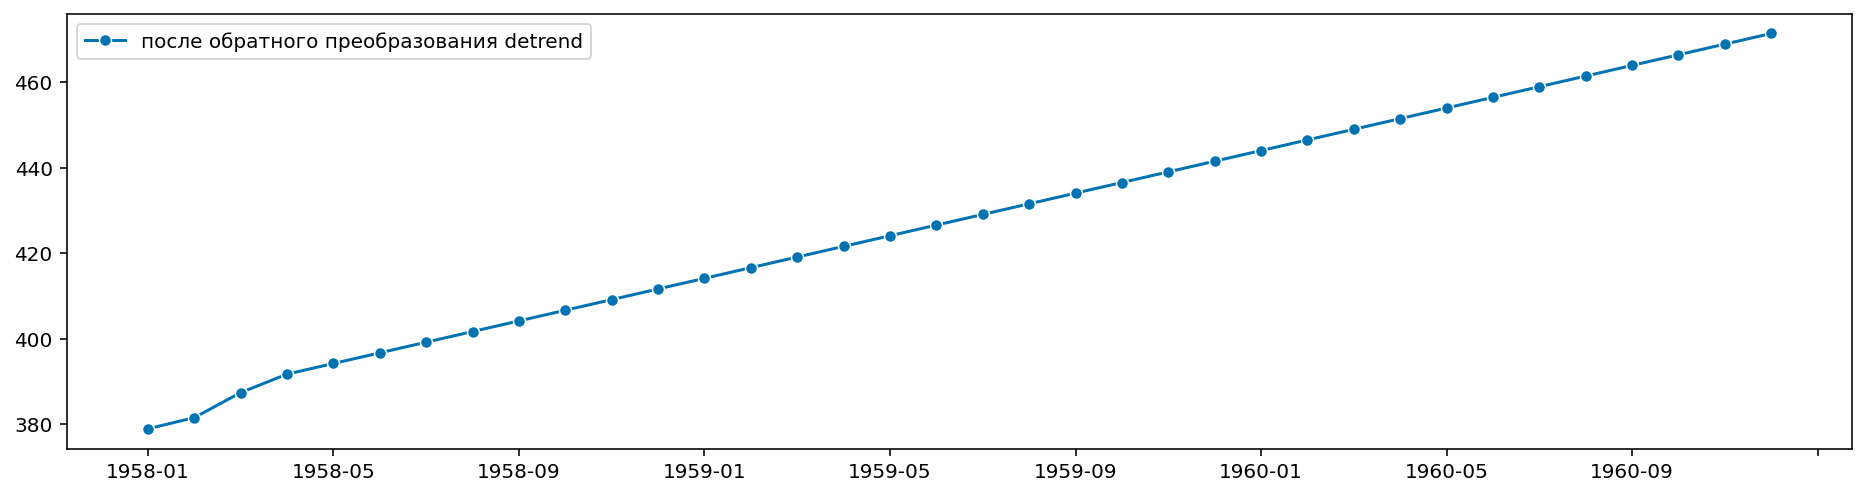

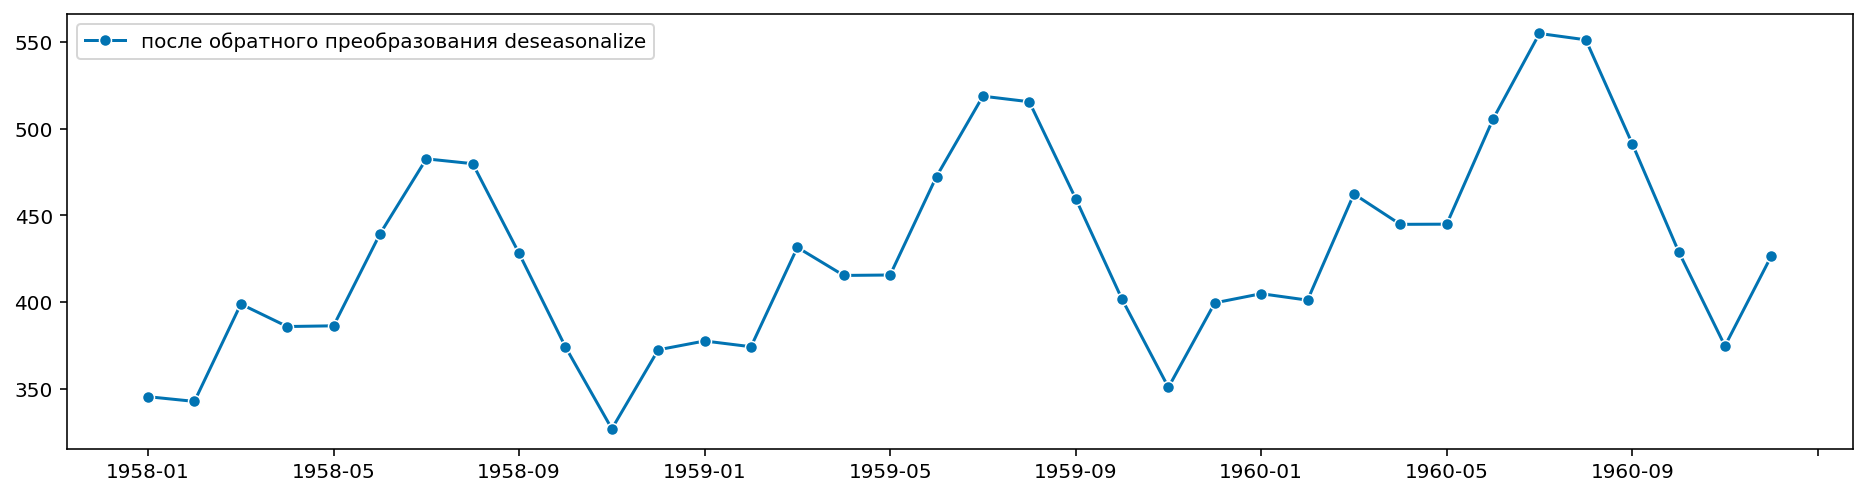

In [43]:
# сделаем копию прогнозов для проверочного временного ряда, 
# чтобы не изменять их в процессе обратной транформации
al_valid_inv_trans_pred = al_valid_trans_pred.copy()

# выполняем обратную транформацию прогнозов бустинга 
# для проверочного временного ряда
for idx, (name, transformer) in enumerate(reversed(transformers)):
    print("Выполняется {}-й шаг из {} шагов обратной трансформации {}".format(
        idx+1, len(transformers), name))
    # с помощью уже обученного трансформера выполняем обратное 
    # преобразование прогнозов для проверочного временного ряда
    al_valid_inv_trans_pred = transformer.inverse_transform(
        al_valid_inv_trans_pred)
    # печатаем первые 5 прогнозов
    print(al_valid_inv_trans_pred.head())
    print("")
    # cмотрим на изменение прогнозов после обратной трансформации
    plot_series(al_valid_inv_trans_pred, 
                labels=["после обратного преобразования " + str(name)])

In [44]:
# обучаем прогнозную модель на обучающем временном ряду
forecaster = TransformedTargetForecaster(steps=[
    ('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
    ('detrend', Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ('forecaster', make_reduction(
        regressor, window_length=12, strategy='recursive'))
])
forecaster.fit(al_train)

# получаем прогнозы для проверочного временного ряда
valid_trans_pred_sktime = forecaster.predict(fh)

# напечатаем первые 5 прогнозов
valid_trans_pred_sktime.head()

1958-01    345.536941
1958-02    342.827191
1958-03    398.900287
1958-04    385.960298
1958-05    386.367405
Freq: M, dtype: float64

In [45]:
# cравним прогнозы c добавлением тренда и умножением на сезонные 
# коэффициенты, вычисленные вручную и автоматически
(al_valid_inv_trans_pred == valid_trans_pred_sktime).all()

True

In [46]:
# вычисляем первый прогноз вручную
(al_valid_trans_pred[0] + (al_train_trend_pred[-1] + 
                           linreg_coefs[1])) * seasonal[0]

345.53694091802316

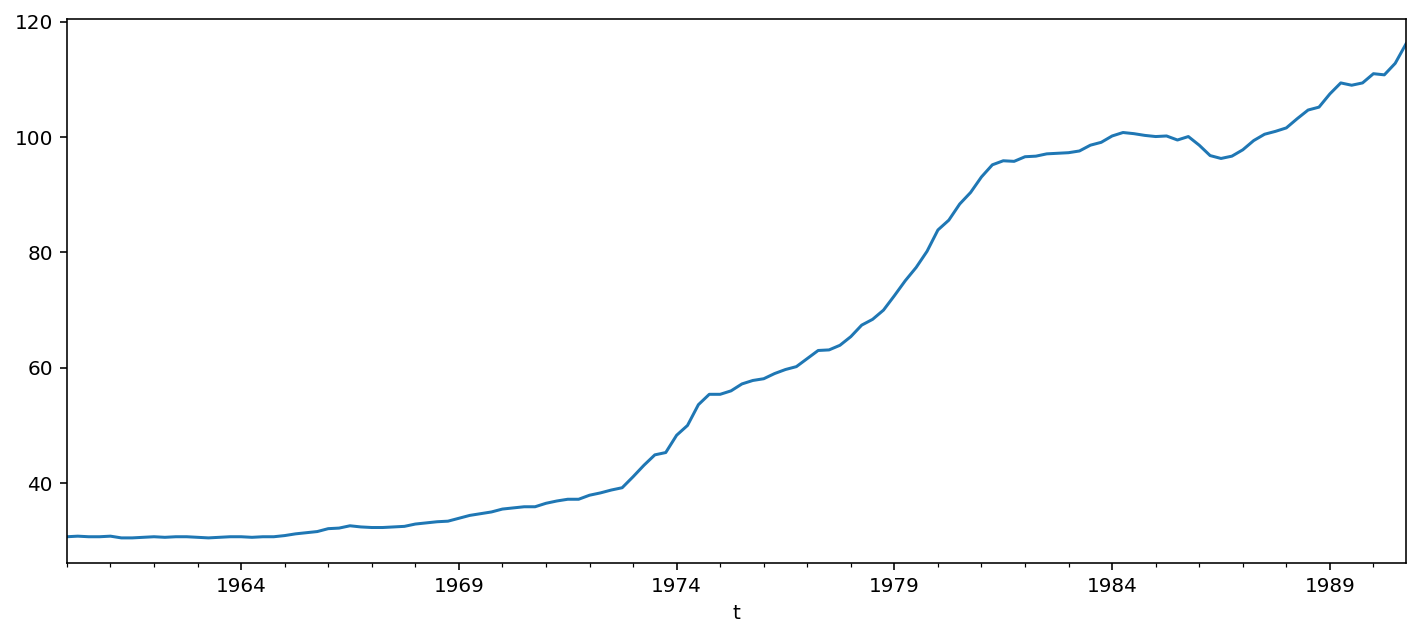

In [47]:
# загружаем данные
df = pd.read_stata('Data/wpi1.dta')
ts_wpi = df.set_index('t').wpi
# визуализируем временной ряд
ts_wpi.plot(figsize=(12, 5))
plt.show();

In [48]:
# присваиваем обучающему набору - серии 
# индекс на основе кварталов годов
ts_wpi.index = ts_wpi.index.to_period('Q')
ts_wpi.head()

t
1960Q1    30.700001
1960Q2    30.799999
1960Q3    30.700001
1960Q4    30.700001
1961Q1    30.799999
Freq: Q-DEC, Name: wpi, dtype: float32

In [49]:
# разбиваем набор на обучающую и проверочную выборки
valid_len = int(len(ts_wpi) * 0.3)
wpi_train, wpi_valid = ts_wpi.iloc[:-valid_len], ts_wpi.iloc[-valid_len:]

best params: {'forecast__window_length': 20}


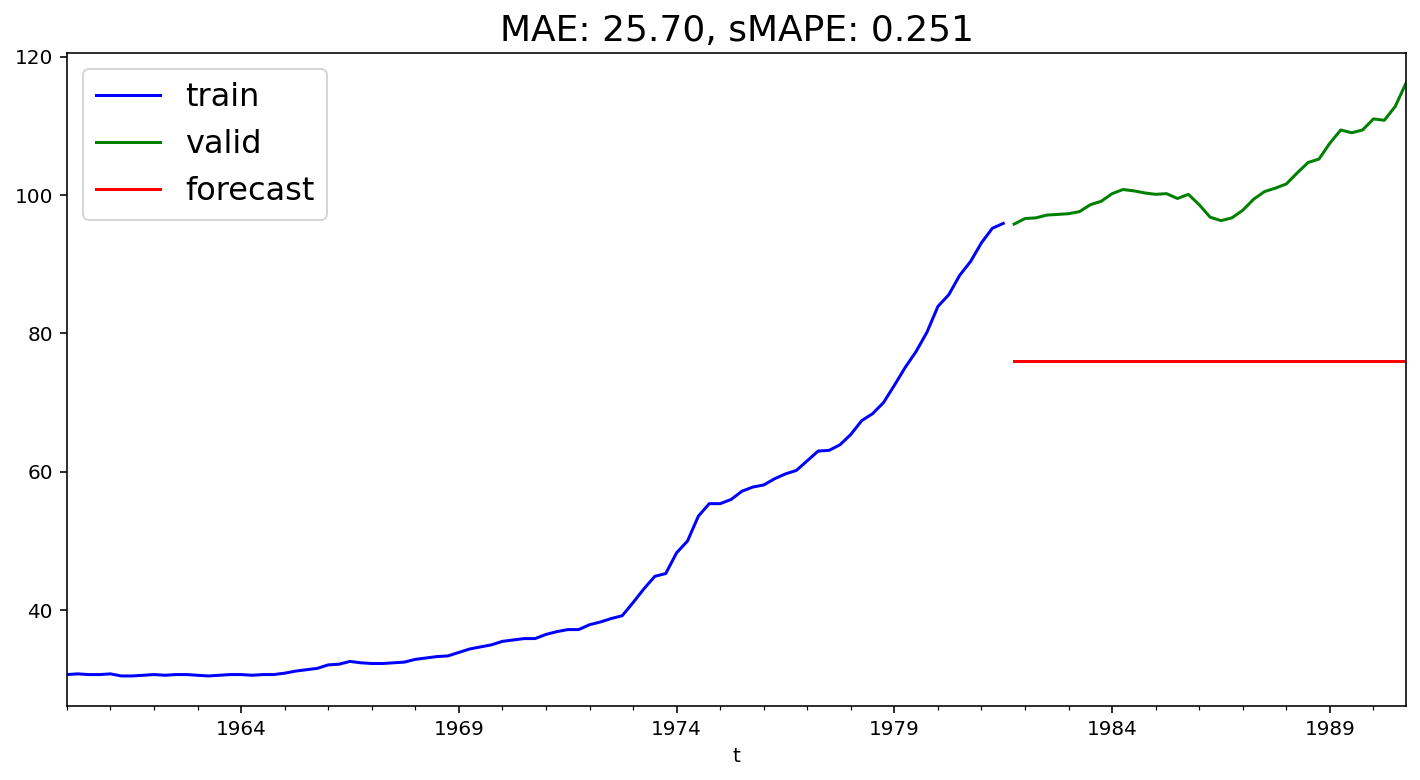

In [50]:
# создаем модель на основе класса LGBMRegressor
regressor = lgb.LGBMRegressor()

# создаем конвейер, состоящий из одной композитной модели (выполнение 
# редукции, т.е. превращение временного ряда в таблицы - массив 
# признаков и массив меток, и обучение модели LightGBM)
forecaster = TransformedTargetForecaster(
    [
        ('forecast', make_reduction(
            regressor, window_length=12, strategy='recursive'))
    ]
)

# задаем сетку гиперпараметров
param_grid = {'forecast__window_length': [5, 10, 15, 20, 25, 30]}

# запускаем поиск и по результатам визуализируем прогнозы 
# с выводом метрик MAE и sMAPE
wpi_lgb_mae, wpi_lgb_mape = grid_search_forecaster(
    wpi_train, wpi_valid, forecaster, param_grid
)

best params: {'forecast__window_length': 20}


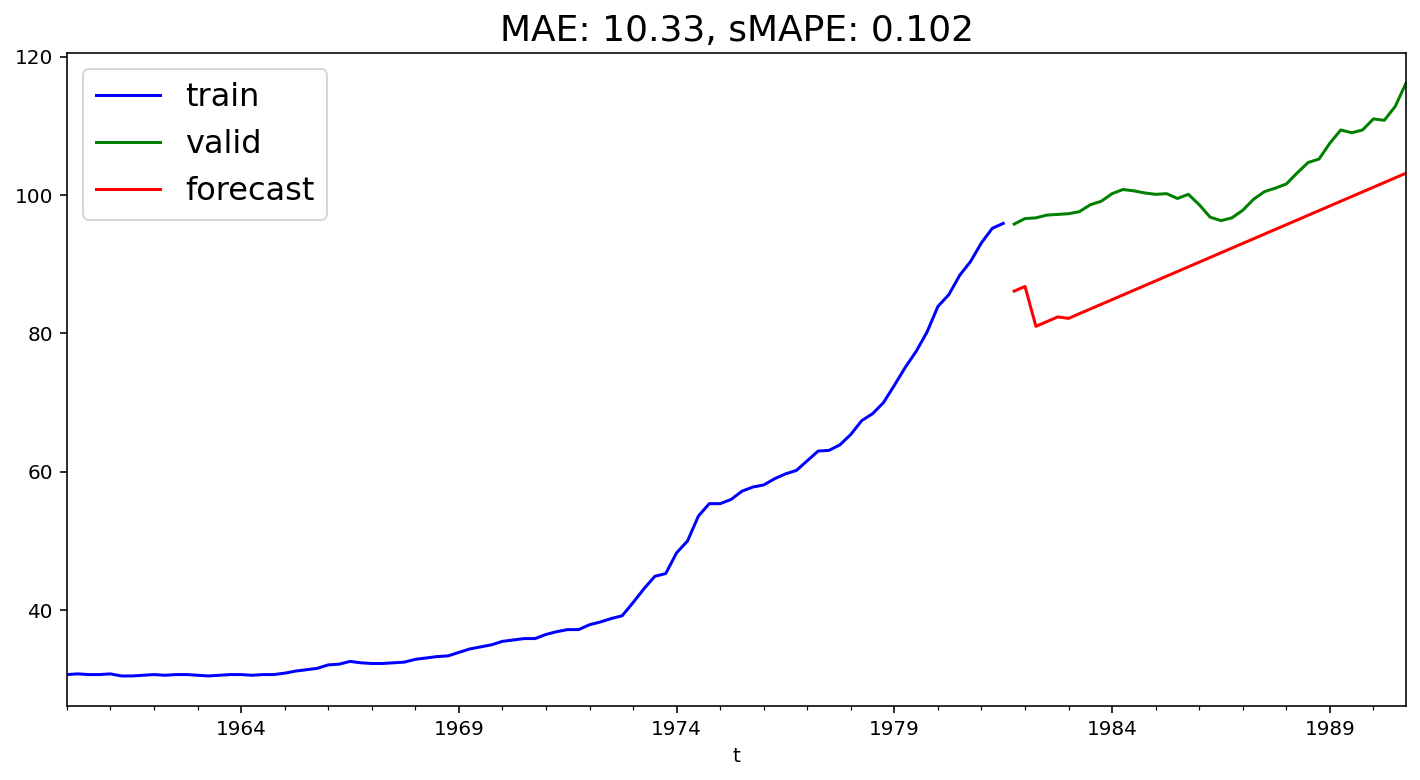

In [51]:
# создаем конвейер, состоящий из детрендера и композитной модели
forecaster = TransformedTargetForecaster(
    [
        ('detrend', Detrender(
            forecaster=PolynomialTrendForecaster(degree=1))),
        ('forecast', make_reduction(
            regressor, window_length=12, strategy='recursive'))
    ]
)

# визуализируем прогнозы с выводом метрик MAE и sMAPE
wpi_lgb_mae, wpi_lgb_mape = grid_search_forecaster(
    wpi_train, wpi_valid, forecaster, param_grid
)